In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
# Load dataset
df = pd.read_csv('/content/concrete_data - concrete_data.csv')

# Convert all columns to numeric, forcing errors to NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values (caused by conversion errors)
df.dropna(inplace=True)

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into features and target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [3]:
# Feature Selection: Remove low-importance features (if applicable)
correlation_matrix = X.corr().abs()
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
X = X.drop(columns=to_drop)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Optimize KNN model using GridSearchCV
param_grid = {'n_neighbors': range(5, 25, 2), 'weights': ['uniform', 'distance']}
knn_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=10, scoring='r2')
knn_search.fit(X_train_scaled, y_train)
best_knn = knn_search.best_estimator_

# Initialize models with optimized hyperparameters
models = {
    'KNN': best_knn,
    'SVR': SVR(kernel='rbf', C=300, gamma='scale', epsilon=0.05),
    'XGBoost': XGBRegressor(n_estimators=700, learning_rate=0.015, max_depth=12, subsample=0.85, colsample_bytree=0.85, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=500, max_depth=25, min_samples_split=4, min_samples_leaf=2, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='r2')

    results[name] = {
        'Train R2': r2_score(y_train, y_pred_train),
        'Test R2': r2_score(y_test, y_pred_test),
        'CV R2 Mean': np.mean(cv_scores),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAPE': np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    }

In [5]:
# ANN Model with improvements
ann = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1)
])
ann.compile(optimizer='adam', loss='mse')
history = ann.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)

y_pred_train_ann = ann.predict(X_train_scaled).flatten()
y_pred_test_ann = ann.predict(X_test_scaled).flatten()
cv_scores_ann = cross_val_score(best_knn, X_train_scaled, y_train, cv=10, scoring='r2')

results['ANN'] = {
    'Train R2': r2_score(y_train, y_pred_train_ann),
    'Test R2': r2_score(y_test, y_pred_test_ann),
    'CV R2 Mean': np.mean(cv_scores_ann),
    'Train MAE': mean_absolute_error(y_train, y_pred_train_ann),
    'Test MAE': mean_absolute_error(y_test, y_pred_test_ann),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_ann)),
    'MAPE': np.mean(np.abs((y_test - y_pred_test_ann) / y_test)) * 100
}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
               Train R2   Test R2  CV R2 Mean  Train MAE  Test MAE      RMSE  \
KNN            0.993214  0.766734    0.765385   0.292027  4.744266  7.824737   
SVR            0.866786  0.850780    0.797370   3.405697  4.229677  6.258314   
XGBoost        0.992739  0.922888    0.900252   0.480456  2.917217  4.498886   
Random Forest  0.960485  0.888059    0.856551   2.096117  3.696867  5.420490   
ANN            0.816690  0.795015    0.765385   4.995376  5.123919  7.335094   

                    MAPE  
KNN            15.263080  
SVR            13.209774  
XGBoost         8.945502  
Random Forest  11.861217  
ANN            16.651474  


<ipython-input-6-49fc40f54197>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['Test R2'], palette='viridis')


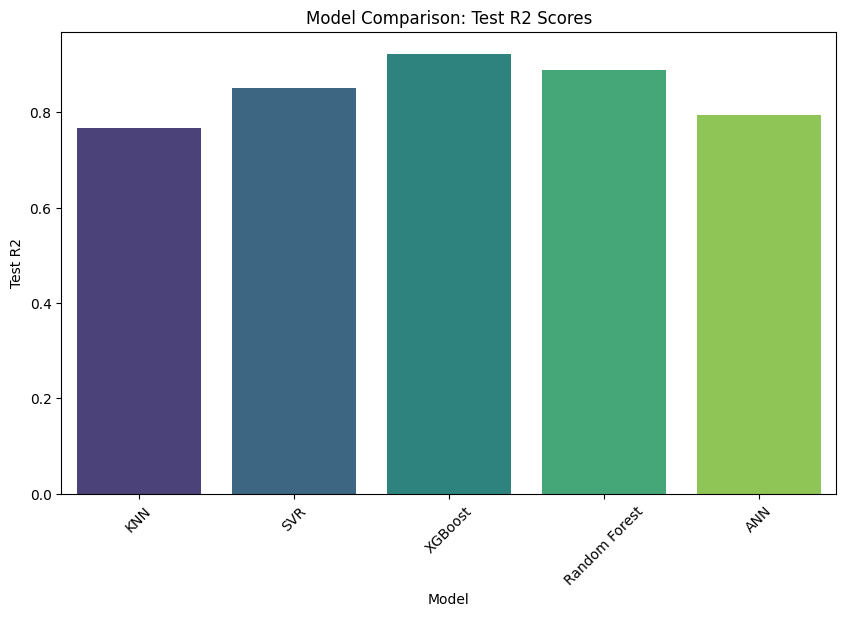

In [6]:
# Visualization

# 1. Bar Plot of R2 Scores
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['Test R2'], palette='viridis')
plt.title('Model Comparison: Test R2 Scores')
plt.ylabel('Test R2')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

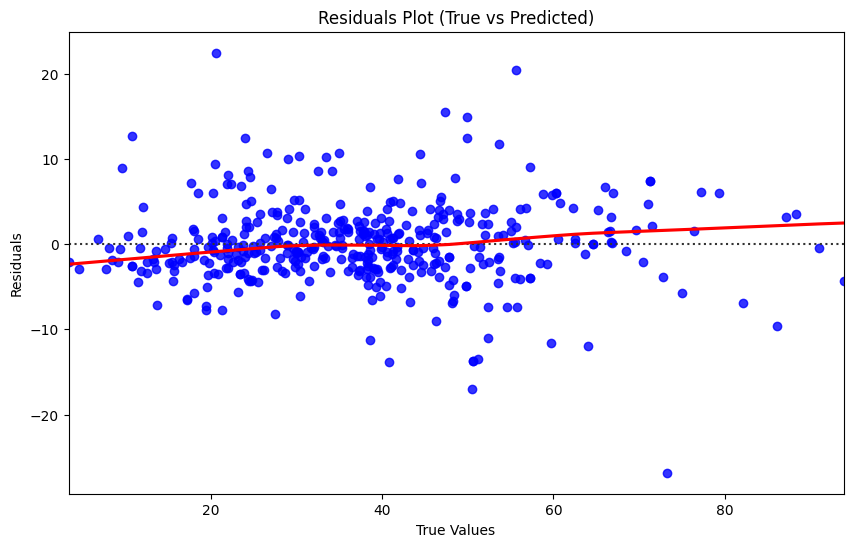

In [7]:
# 2. Residuals Plot for Error Analysis (Fixed Issue)
plt.figure(figsize=(10, 6))
sns.residplot(x=y_test, y=y_pred_test, lowess=True, color='blue', line_kws={'color': 'red'})
plt.title('Residuals Plot (True vs Predicted)')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()

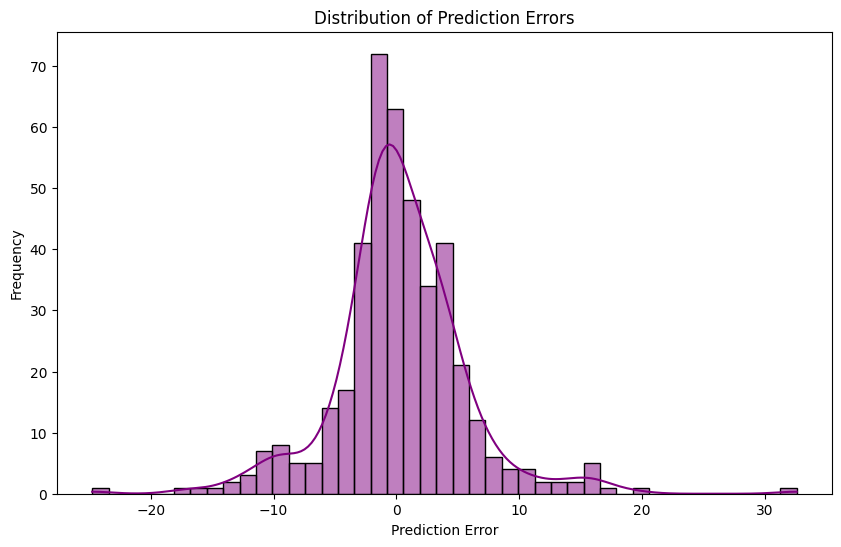

In [8]:
# 3. Distribution of Errors (Mean Absolute Error)
errors = y_test - y_pred_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color='purple')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

<ipython-input-9-84fef4a5d830>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X.columns, y=importances_rf, palette='Blues_d')


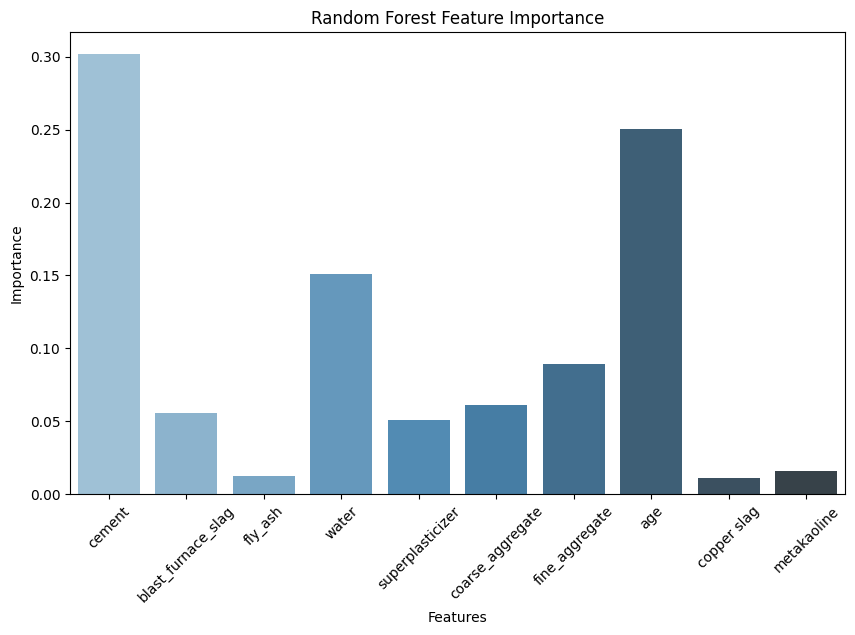

In [9]:
# 4. Feature Importance Plot (for Random Forest and XGBoost)
# Random Forest Feature Importance
plt.figure(figsize=(10, 6))
importances_rf = models['Random Forest'].feature_importances_
sns.barplot(x=X.columns, y=importances_rf, palette='Blues_d')
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

<ipython-input-10-20defacaec9e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X.columns, y=importances_xgb, palette='Blues_d')


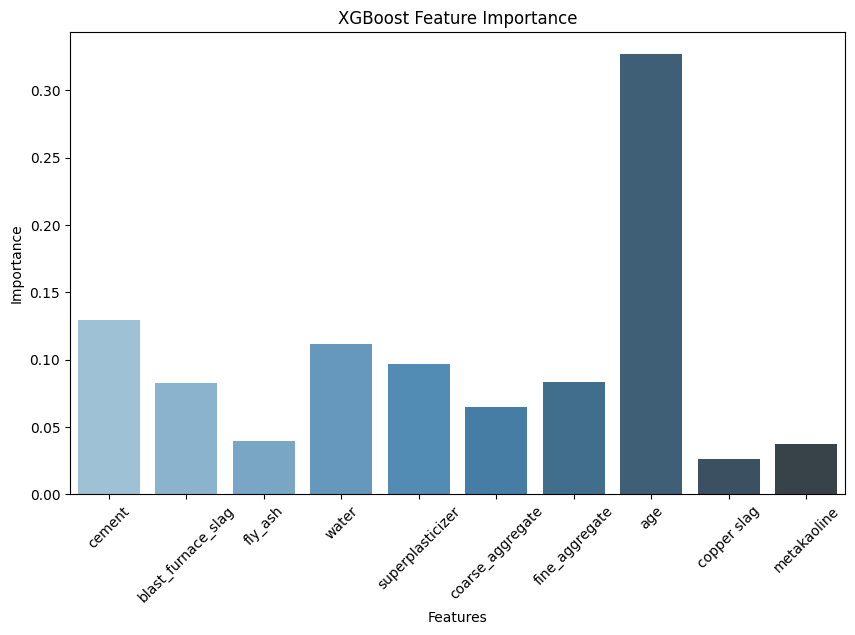

In [10]:
# XGBoost Feature Importance
plt.figure(figsize=(10, 6))
importances_xgb = models['XGBoost'].feature_importances_
sns.barplot(x=X.columns, y=importances_xgb, palette='Blues_d')
plt.title('XGBoost Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

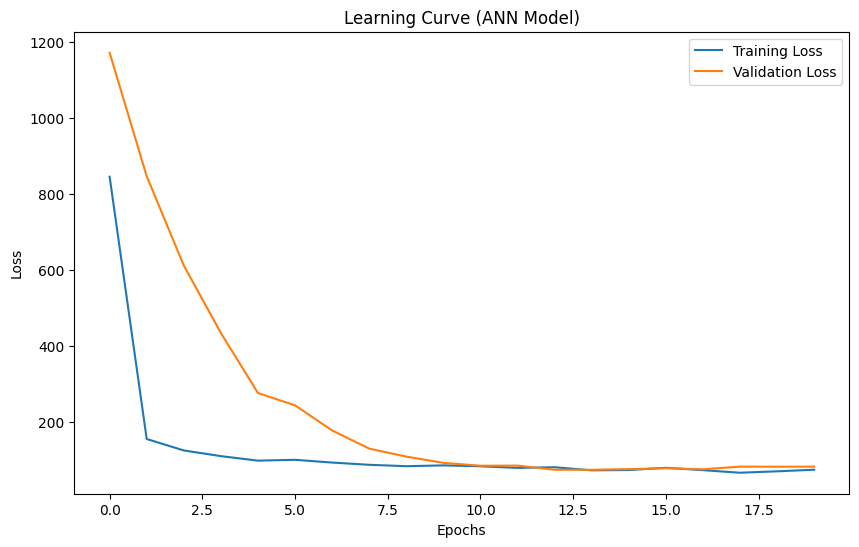

In [11]:
# 5. Learning Curves (for ANN)
# Check if 'loss' and 'val_loss' exist in the history
if 'loss' in history.history and 'val_loss' in history.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Learning Curve (ANN Model)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print("No loss or validation loss available for plotting.")

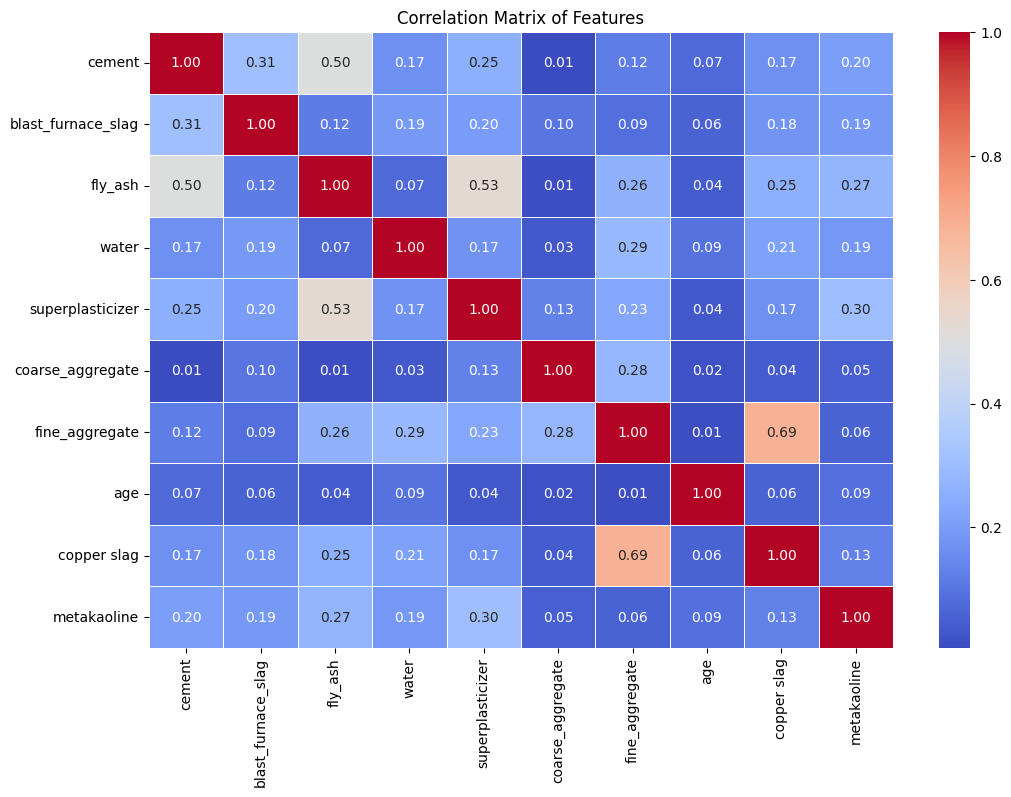

In [12]:
# 6. Heatmap of the Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

In [13]:
# Function for user input prediction
def predict_concrete_strength():
    print("Enter the input values for prediction:")
    input_data = []
    for col in X.columns:
        while True:
            try:
                value = float(input(f"Enter value for {col}: "))
                break
            except ValueError:
                print("Invalid input. Please enter a numeric value.")
        input_data.append(value)

    input_data = np.array(input_data).reshape(1, -1)
    input_data_scaled = scaler.transform(input_data)

    print("Select a model for prediction:")
    model_options = list(models.keys()) + ["ANN"]
    for idx, model_name in enumerate(model_options, start=1):
        print(f"{idx}. {model_name}")

    while True:
        try:
            choice = int(input("Enter the number of the model: "))
            if 1 <= choice <= len(model_options):
                break
            else:
                print("Invalid choice. Please enter a valid number.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    selected_model_name = model_options[choice - 1]

    if selected_model_name == "ANN":
        prediction = ann.predict(input_data_scaled).flatten()[0]
    else:
        prediction = models[selected_model_name].predict(input_data_scaled)[0]

    print(f"Predicted Concrete Strength using {selected_model_name}: {prediction:.2f} MPa")

In [15]:
# Call the function if needed
predict_concrete_strength()

Enter the input values for prediction:
Enter value for cement: 475
Enter value for blast_furnace_slag: 0
Enter value for fly_ash: 0
Enter value for water: 228
Enter value for superplasticizer: 0
Enter value for coarse_aggregate: 932
Enter value for fine_aggregate: 594
Enter value for age: 28
Enter value for copper slag: 0
Enter value for metakaoline: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Select a model for prediction:
1. KNN
2. SVR
3. XGBoost
4. Random Forest
5. ANN
Enter the number of the model: 2
Predicted Concrete Strength using SVR: 38.28 MPa
